In [1]:
import os
import pickle
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from utils import tools, losses
from datasets.lunar_analogue import LunarAnalogueDataGenerator
from modules.pca_base_module import PCABaseModule

%matplotlib inline
plt.style.use('seaborn')

In [2]:
DEFAULT_CONFIG_FILE = 'configs/incremental_pca.yaml'
config = tools.config_from_command_line(os.path.join(os.getcwd(), '..', DEFAULT_CONFIG_FILE))

# Initialize datagenerator
datagenerator = LunarAnalogueDataGenerator(config, stage='test')

with open('../models/saved-models/IncrementalPCA/LunarAnalogue-WholeImage.p', 'rb') as f:
    model = pickle.load(f)
with open('../logs/IncrementalPCA/LunarAnalogue-WholeImage-ValidationNoveltyScores.p', 'rb') as f:
    val_novelty_scores = pickle.load(f)

# Initialize experimental module
module = PCABaseModule(datagenerator, model, config)

Experimental parameters
------
root_data_path: /home/brahste/Datasets/LunarAnalogue
glob_pattern_train: **/nov-labelled/trainval/*.jpeg
glob_pattern_test: **/nov-labelled/test/**/*.jpeg
train_fraction: 0.9
batch_size: 200
experiment_name: IncrementalPCA
log_directory: experiments/logs 

Loading LunarAnalogueDataGenerator
------
Testing samples: 968



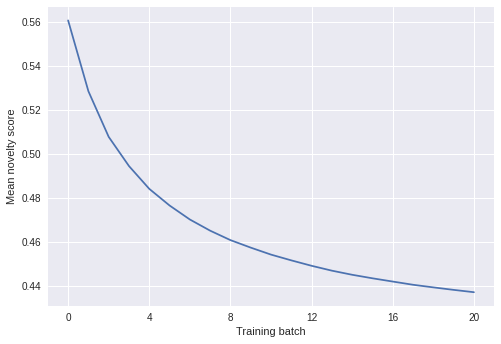

In [3]:
# Check validation curve produced during training
val_novelty_scores_means = [np.mean(x) for x in val_novelty_scores]

plt.plot(val_novelty_scores_means)
plt.xlabel('Training batch'); plt.ylabel('Mean novelty score')
plt.xticks(range(0, len(val_novelty_scores_means), 4))
plt.show()

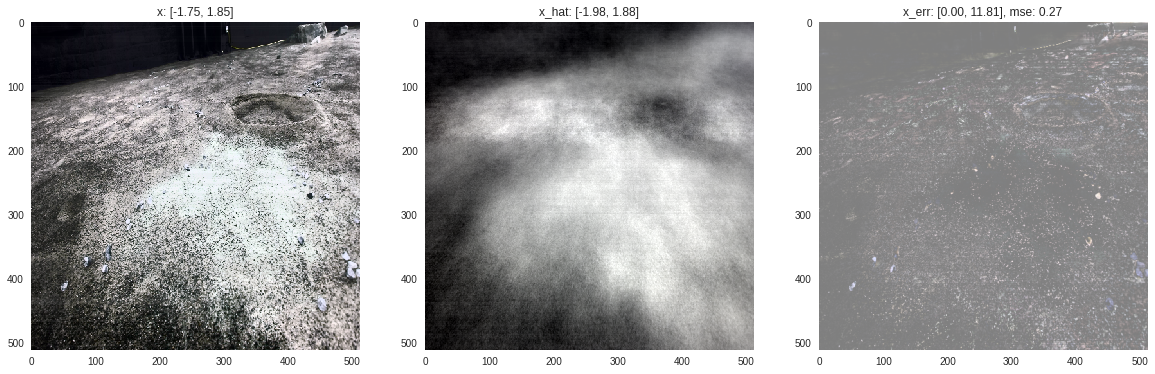

[BATCH 0] Transforming...
[BATCH 1] Transforming...
[BATCH 2] Transforming...
[BATCH 3] Transforming...


In [4]:
# Caution: this cell takes a while to finish
test_novelty_scores, test_novelty_labels = module.transform_pipeline()

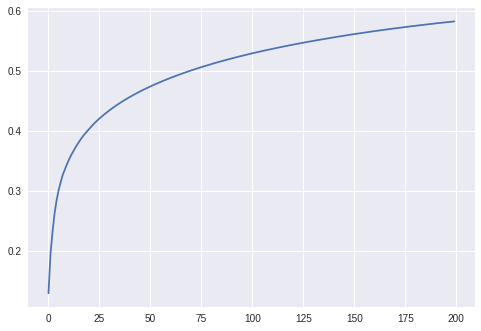

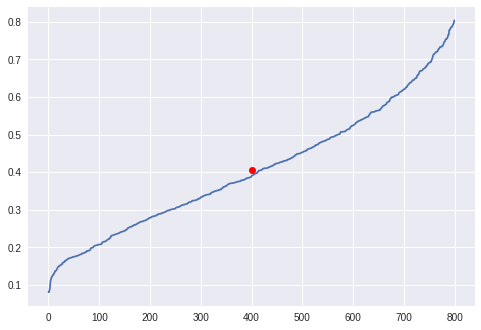

In [18]:
module.model.explained_variance_ratio_.cumsum()
plt.plot(module.model.explained_variance_ratio_.cumsum())
plt.show()

plt.plot(sorted(test_novelty_scores))
plt.plot(len(test_novelty_scores)/2, np.mean(test_novelty_scores), 'ro')
plt.show()

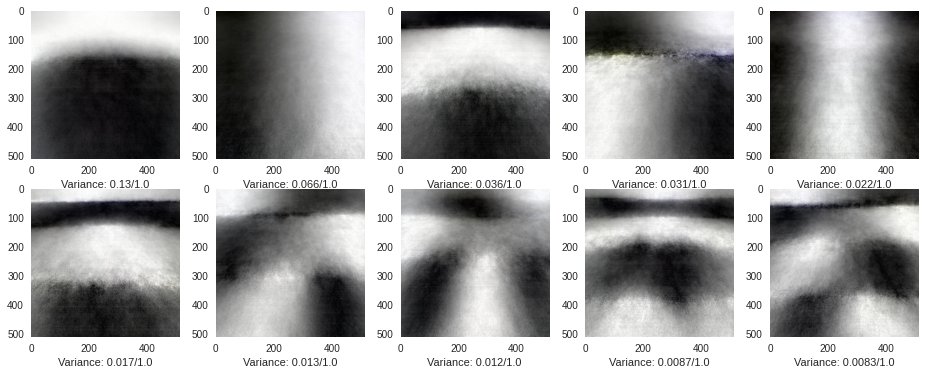

In [6]:
comps = module.components
b = 0

fig, ax = plt.subplots(2, 5, figsize=(16, 6))

# If you want to remove the number from the x,y axes then look into
# mpl.rcParams and set values such as 'axes.spines.left/right' or
# xtick/ytick.left/bottom'
for i in range(2):
    for j in range(5):
        ax[i, j].grid(False)
        ax[i, j].imshow(tools.unstandardize_batch(comps[i*5 + j].reshape(512, 512, 3)))
        ax[i, j].set_xlabel(f'Variance: {module.explained_variance_ratio[i*5 + j]:.2}/1.0')
    
plt.show()

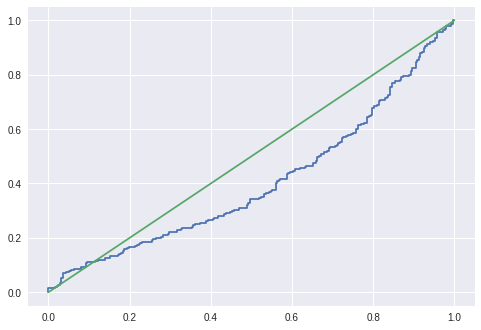

Model ROC AUC:  0.40530500521376434
Random ROC AUC:  0.5


In [17]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(test_novelty_labels, test_novelty_scores)
roc_auc_score = metrics.roc_auc_score(test_novelty_labels, test_novelty_scores)
roc_auc_score_rand = metrics.roc_auc_score([*[0.]*400, *[1.]*400], [0.5]*800)

plt.plot(fpr, tpr)
plt.plot([0., 1.], [0., 1.])
plt.show()
print('Model ROC AUC: ', roc_auc_score)
print('Random ROC AUC: ', roc_auc_score_rand)